In [29]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_lattice as tfl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(1)

In [30]:
# DATA
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

n_train = 128

# trainning set
Tz_k   = np.array(df['room_temp']).reshape(-1,1)[0: n_train]
Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[1: n_train+1]
msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[1: n_train+1]
Tz_k1  = np.array(df['room_temp']).reshape(-1,1)[1: n_train+1]

X = np.concatenate((Tz_k, Tsa_k1, msa_k1), axis=1)
Y = np.copy(Tz_k1)

# test set
Tz_k_t   = np.array(df['room_temp']).reshape(-1,1)[n_train: 1600]
Tsa_k1_t = np.array(df['supply_discharge_temp']).reshape(-1,1)[n_train+1: 1600+1]
msa_k1_t = np.array(df['airflow_current']).reshape(-1,1)[n_train+1: 1600+1]
Tz_k1_t  = np.array(df['room_temp']).reshape(-1,1)[n_train+1: 1600+1]

X_t = np.concatenate((Tz_k_t, Tsa_k1_t, msa_k1_t), axis=1)
Y_t = np.copy(Tz_k1_t)

In [31]:
# combined calibrator
combined_calibrators = tfl.layers.ParallelCombination()

calibrator_x1 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(65,  85,  10), output_min=0, output_max=2)
calibrator_x2 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(50,  100, 10), output_min=0, output_max=2, monotonicity='increasing')
calibrator_x3 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(390, 1010,10), output_min=0, output_max=2)

combined_calibrators.append(calibrator_x1)
combined_calibrators.append(calibrator_x2)
combined_calibrators.append(calibrator_x3)

# Lattice
lattice = tfl.layers.Lattice(
    lattice_sizes = [3, 3, 3],
    monotonicities = ['increasing', 'increasing', 'increasing'],
    output_min = 65,
    output_max = 85)

In [32]:
inps  = tf.keras.Input(shape=(3,))
calib = combined_calibrators(inps)
outs  = lattice(calib)

model = tf.keras.Model(inputs=inps, outputs=outs)

In [33]:
model.compile(
    loss = tf.keras.losses.mean_squared_error,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = [tfa.metrics.RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

hist = model.fit(
    x = X,
    y = Y,
    batch_size = 256,
    epochs = 1000,
    shuffle = False,
    validation_data=(X_t, Y_t),
    callbacks=[callback],
    verbose = 1)

Epoch 1/1000
1/1 [==============================] - 1s 810ms/step - loss: 20.4175 - r_square: -5.7400 - val_loss: 11.2583 - val_r_square: -2.3131
Epoch 2/1000
1/1 [==============================] - 0s 18ms/step - loss: 18.6551 - r_square: -5.1582 - val_loss: 10.6028 - val_r_square: -2.1202
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - loss: 17.0009 - r_square: -4.6122 - val_loss: 9.8774 - val_r_square: -1.9067
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 15.2412 - r_square: -4.0313 - val_loss: 9.0900 - val_r_square: -1.6750
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 13.3980 - r_square: -3.4228 - val_loss: 8.4184 - val_r_square: -1.4774
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 11.7430 - r_square: -2.8765 - val_loss: 7.8265 - val_r_square: -1.3032
Epoch 7/1000
1/1 [==============================] - 0s 18ms/step - loss: 10.2329 - r_square: -2.3780 - val_loss: 7.2598 - val_r_squar

999
0.9852842092514038


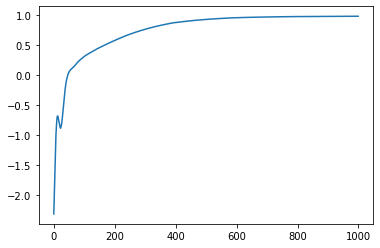

In [34]:
a = np.argmax(hist.history['val_r_square'])
print(a)
print(hist.history['val_r_square'][a])
# plot metrics
plt.plot(hist.history['val_r_square'])
plt.show()

46/46 [==============================] - 0s 556us/step - loss: 0.0500 - r_square: 0.9853
R2 test data: 0.9852783679962158


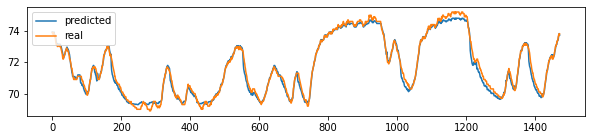

In [35]:
print("R2 test data:", model.evaluate(X_t, Y_t)[1])

plt.figure(figsize=(10,2))
plt.plot(model(X_t), label='predicted')
plt.plot(Y_t, label='real')
plt.legend()
plt.show()